In [1]:
import numpy as np
import matplotlib.pylab as ply
%matplotlib inline
import healpy as hp
from test_rolling import gen_greedy_surveys, generate_blobs, slice_wfd_area

from lsst.sims.featureScheduler.modelObservatory import Model_observatory
from lsst.sims.featureScheduler.schedulers import Core_scheduler
from lsst.sims.featureScheduler.utils import standard_goals, create_season_offset, schema_converter
import lsst.sims.featureScheduler.basis_functions as bf
from lsst.sims.featureScheduler.surveys import (generate_dd_surveys, Greedy_survey,
                                                Blob_survey)
from lsst.sims.featureScheduler import sim_runner
import lsst.sims.featureScheduler.detailers as detailers
from lsst.sims.featureScheduler import utils


In [2]:
max_dither = 0.7
nside=32
nexp=1
per_night=True
mod_year=2
scale_down_factor = 0.2

observatory = Model_observatory(nside=nside)
conditions = observatory.return_conditions()

# Mark position of the sun at the start of the survey. Usefull for rolling cadence.
sun_ra_0 = conditions.sunRA  # radians
offset = create_season_offset(nside, sun_ra_0) + 365.25

dither_detailer = detailers.Dither_detailer(per_night=per_night, max_dither=max_dither)
details = [detailers.Camera_rot_detailer(min_rot=-87., max_rot=87.), dither_detailer]
ddfs = generate_dd_surveys(nside=nside, nexp=nexp, detailers=details)


sg = standard_goals()
roll_maps = slice_wfd_area(mod_year, sg, scale_down_factor=scale_down_factor)
footprints = roll_maps + [sg]

all_footprints_sum = 0
all_rolling_sum = 0

wfd_indx = np.where(sg['r'] == 1)
for fp in sg:
    all_footprints_sum += np.sum(sg[fp])
    all_rolling_sum += np.sum(sg[fp][wfd_indx])



/Users/yoachim/gitRepos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:377: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')
/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/modelObservatory/model_observatory.py:475: RuntimeWarning: invalid value encountered in less
  slewtimes[np.where(slewtimes < 0)] = np.nan


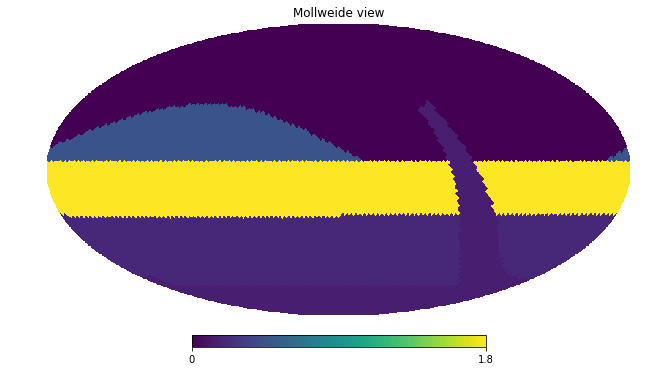

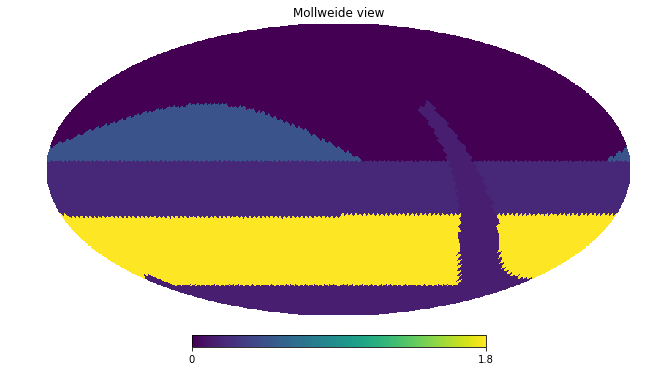

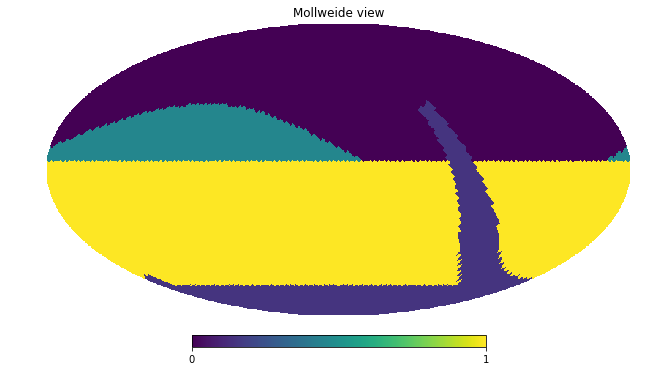

In [3]:
for fp in footprints:
    hp.mollview(fp['r'])

In [4]:
greedy = gen_greedy_surveys(nside, nexp=nexp, footprints=footprints, season_modulo=mod_year, day_offset=offset,
                                all_footprints_sum=all_footprints_sum, all_rolling_sum=all_rolling_sum)
blobs = generate_blobs(nside, nexp=nexp, mixed_pairs=True, day_offset=offset, footprints=footprints, season_modulo=mod_year,
                       all_footprints_sum=all_footprints_sum, all_rolling_sum=all_rolling_sum)
surveys = [ddfs, blobs, greedy]

In [5]:
scheduler = Core_scheduler(surveys, nside=nside)

In [6]:
sc = schema_converter()
observations = sc.opsim2obs('testrolling_v1.4_2yrs.db')

In [7]:
observatory = Model_observatory(nside=nside)

In [8]:
observations[-100]

(428637,  1.68706481, -0.96568436,  60583.34968992,  0.,  30., 'i',  6.24729349, 1,  1.20214907,  0.54338503,  0.81809153,  0.72447124,  20.29867366, 738,  5.91767001,  31.,  0.13176173,  23.82428736,  0.98242119,  2.57076465,  5.32078606,  0., -0.2313972, -0.44964004, 'blob, ri, b', -1, 68, 0,  4.31453264,  5.35667788,  1.50446626,  1.92767206,  0.,  0.,  2.86366039,  0.17429111,  1.4981816,  1.5297233,  14.43401488)

In [9]:
nmax = -100
for obs in observations[0:nmax]:
    scheduler.add_observation(obs)

In [10]:
# Set the observatory to the correct state. Takes a while because it has to load the sky brightness file.
observatory.mjd = obs['mjd']
# Observatory starts parked, so need to send an expose command to slew to the correct position
temp = observatory.observe(obs)
# It took some time to make that slew, so reset the time again
observatory.mjd = obs['mjd']

conditions = observatory.return_conditions()

scheduler.update_conditions(conditions)

/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/modelObservatory/model_observatory.py:475: RuntimeWarning: invalid value encountered in less
  slewtimes[np.where(slewtimes < 0)] = np.nan


/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


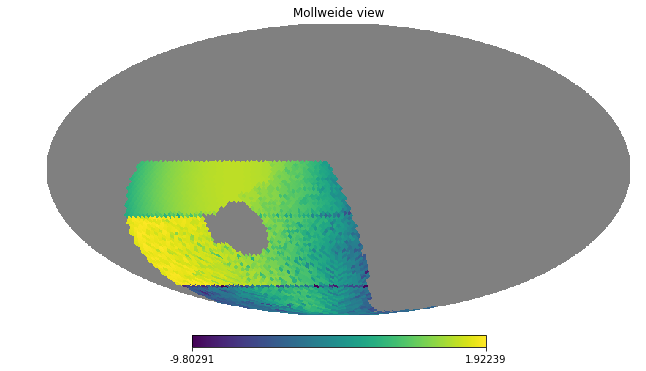

In [13]:
hp.mollview(scheduler.survey_lists[2][3].calc_reward_function(conditions))


/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


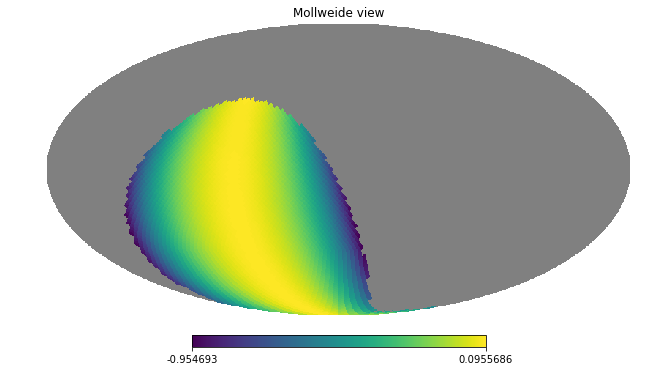

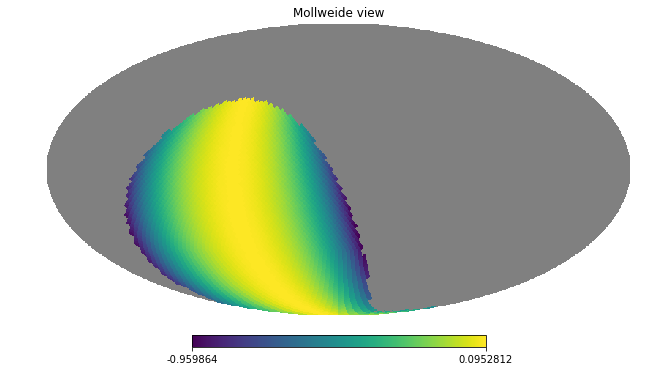

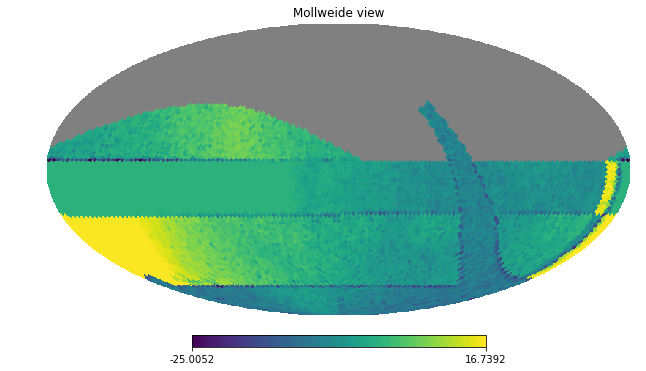

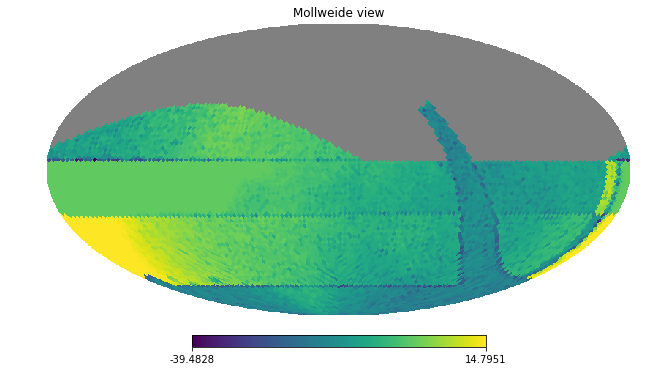

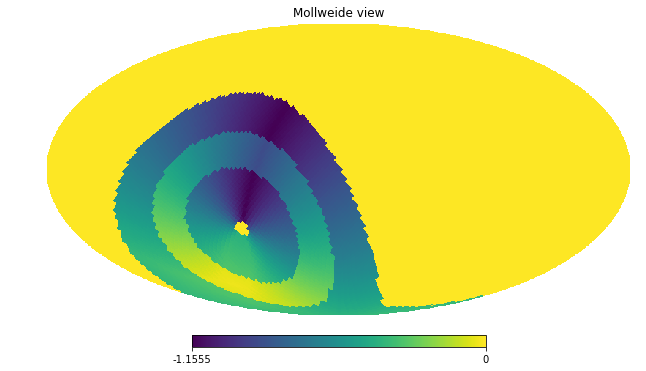

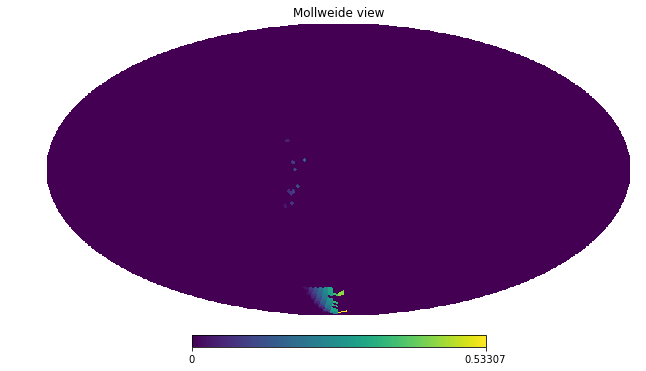

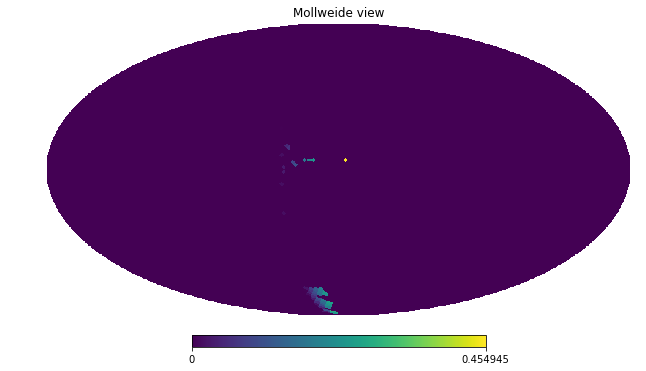

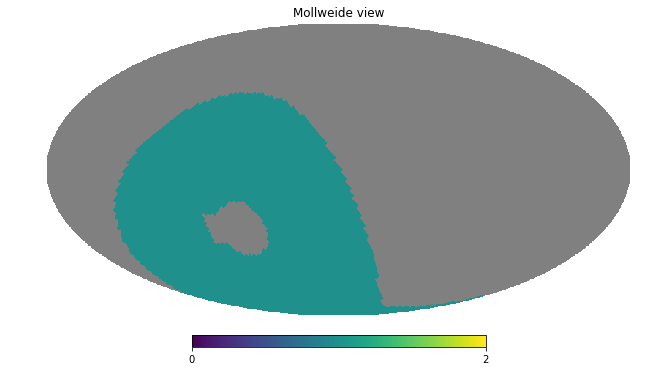

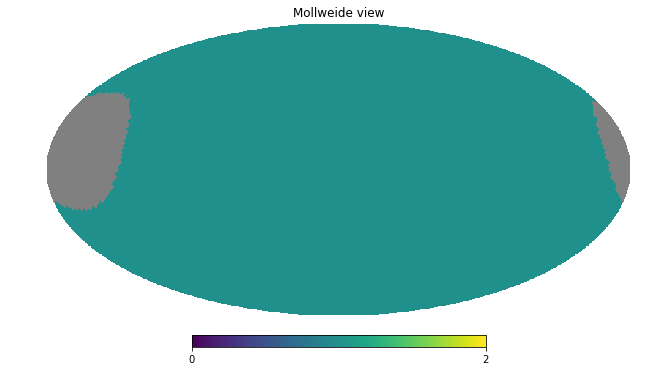

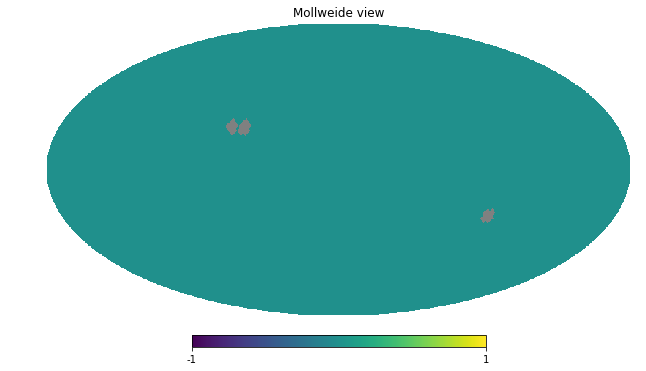

In [14]:
for bf in scheduler.survey_lists[1][3].basis_functions:
    val = bf(conditions)
    if np.size(val) > 1:
        hp.mollview(val)

In [ ]:
hp.mollview(scheduler.survey_lists[1][3].basis_functions[2].survey_features['N_obs_-1'].feature)

In [ ]:
self = scheduler.survey_lists[1][3].basis_functions[2]
result = self.result.copy()

# Compute what season it is at each pixel
seasons = utils.season_calc(conditions.night, offset=self.day_offset,
                            modulo=self.season_modulo, max_season=self.max_season,
                            season_length=self.season_length)

hp.mollview(result)

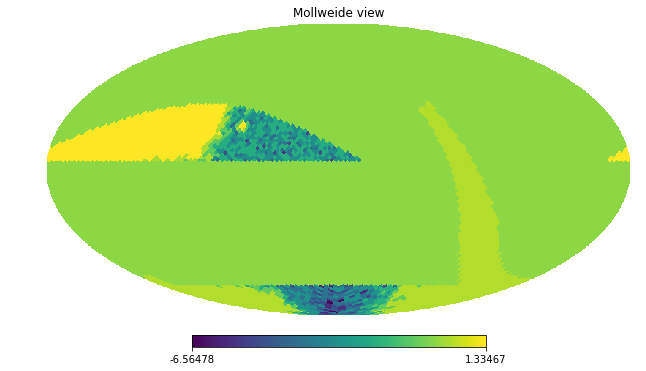

In [16]:
# let's compute the constant parts of the footprint like before
desired = self.footprints[-1] / self.all_footprints_sum * np.sum(self.survey_features['N_obs_all'].feature)
result[self.constant_footprint_indx] = desired[self.constant_footprint_indx] - self.survey_features['N_obs'].feature[self.constant_footprint_indx]

hp.mollview(result)

In [48]:
# Now for the rolling sections
for season in [-1]: #np.unique(seasons[self.rolling_footprint_indx]):
    season_indx = np.where(seasons[self.rolling_footprint_indx] == season)[0]
    desired = self.footprints[season][self.rolling_footprint_indx][season_indx] / self.all_rolling_sum * np.sum(self.survey_features['N_obs_all_%i' % season].feature[self.rolling_footprint_indx])
    result[self.rolling_footprint_indx][season_indx] = desired - self.survey_features['N_obs_%i' % season].feature[self.rolling_footprint_indx][season_indx]



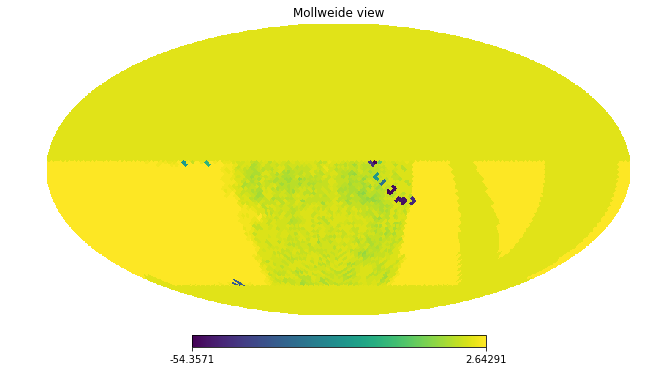

In [50]:
hp.mollview(result)

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


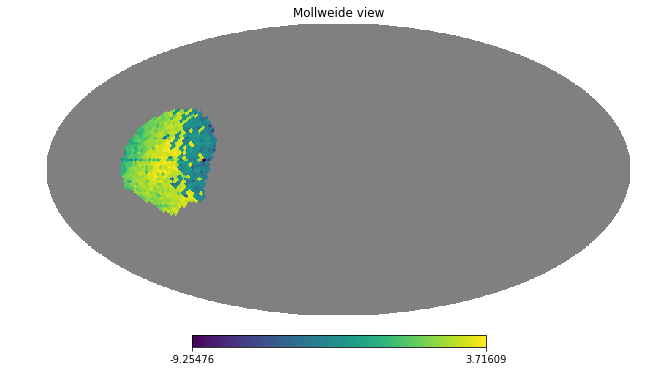

In [15]:
hp.mollview(scheduler.survey_lists[1][1].calc_reward_function(conditions))

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


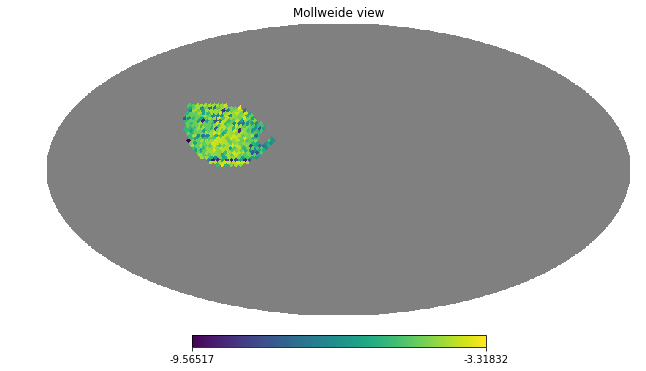

In [17]:
hp.mollview(scheduler.survey_lists[1][4].calc_reward_function(conditions))

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


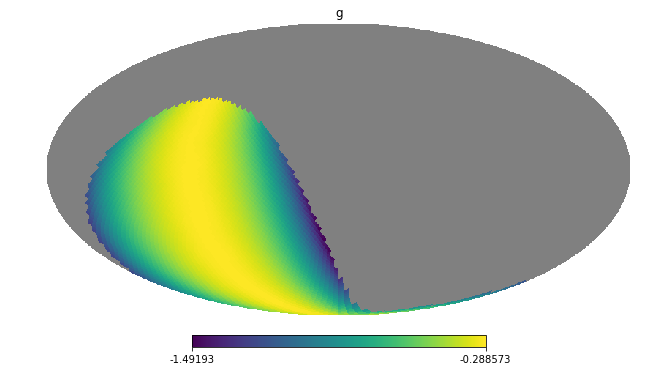

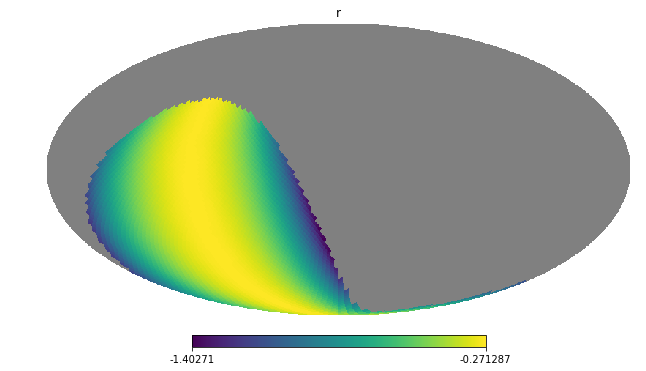

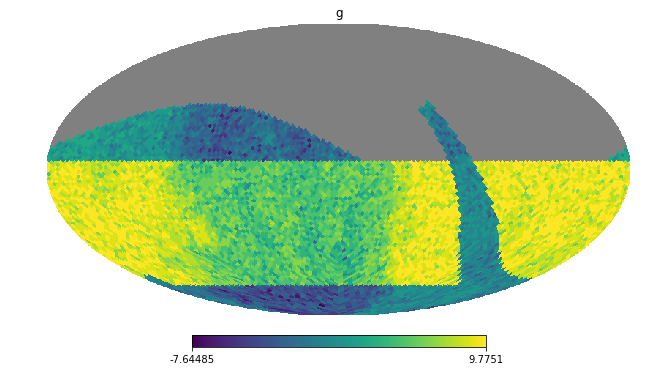

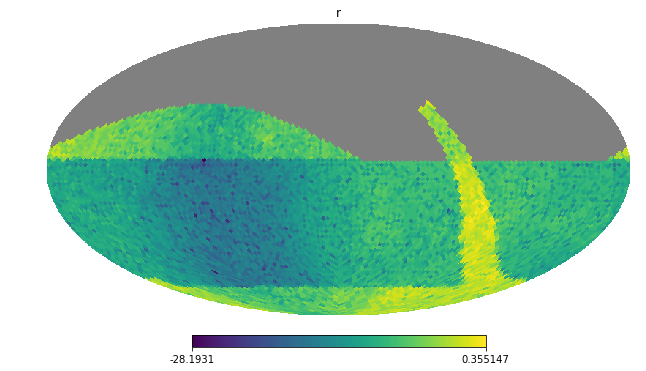

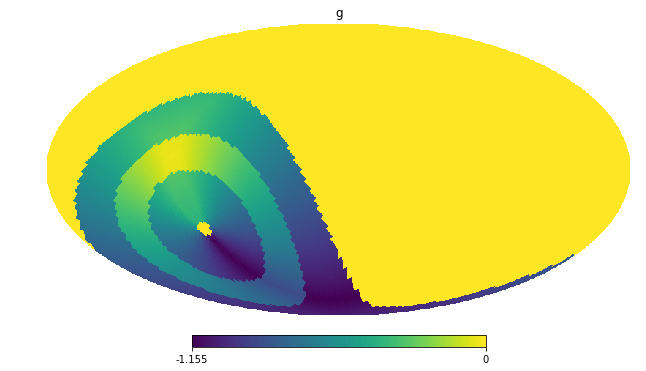

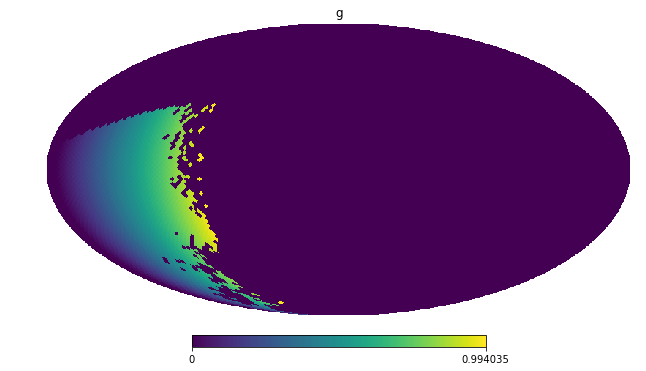

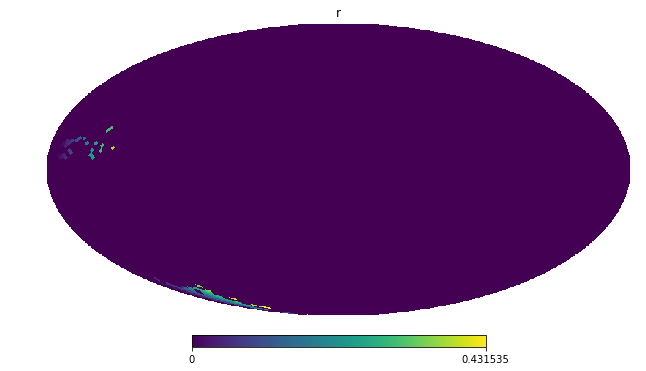

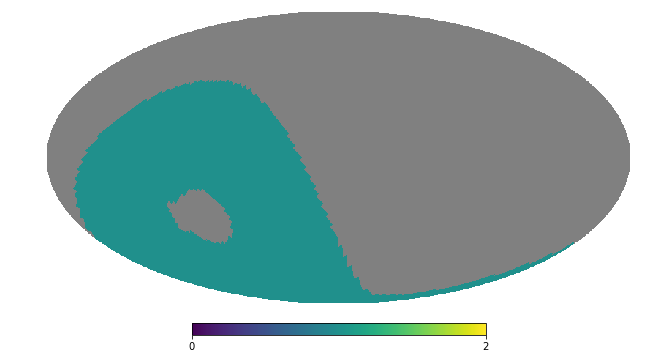

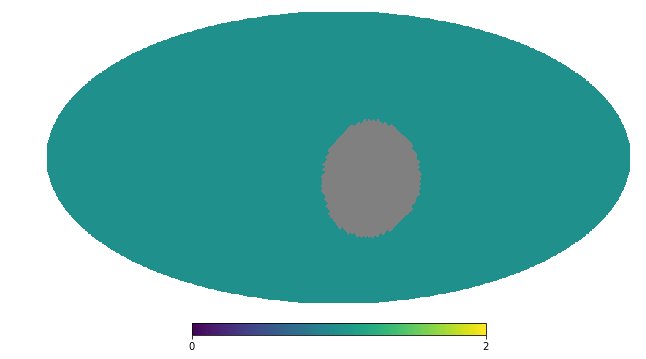

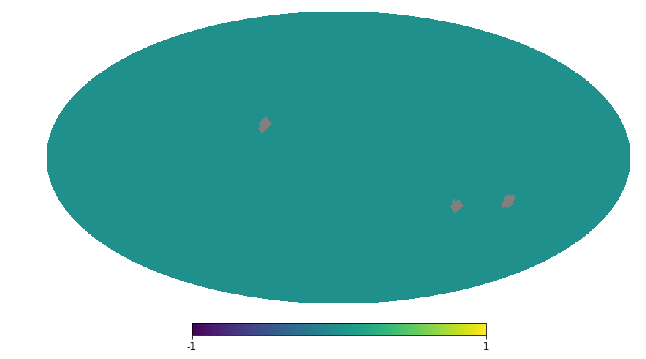

In [30]:
for bf in scheduler.survey_lists[1][1].basis_functions:
    val = bf(conditions)
    title = ''
    try:
        title += bf.filtername
    except:
        pass
    if np.size(val) > 1:
        hp.mollview(val, title=title)

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


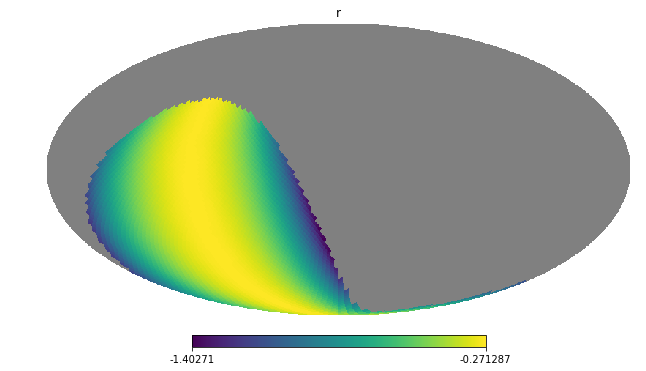

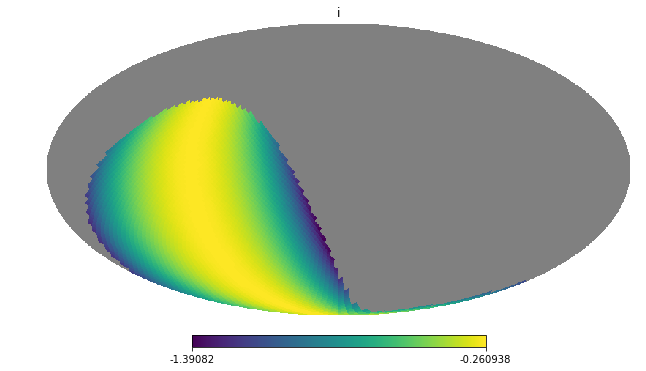

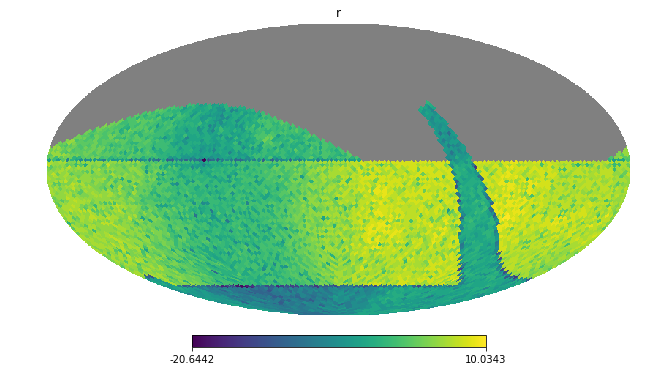

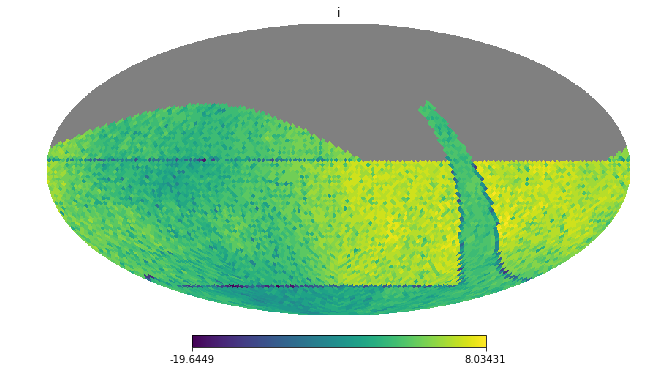

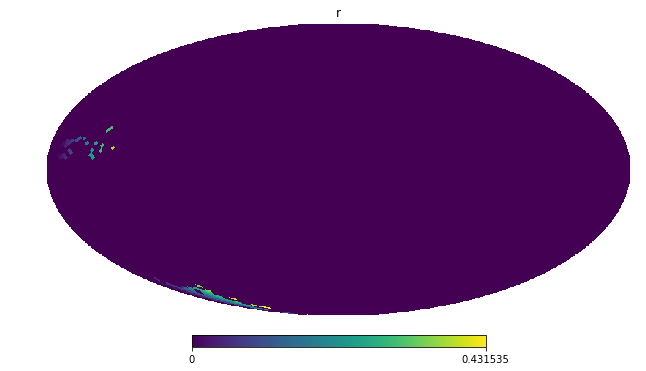

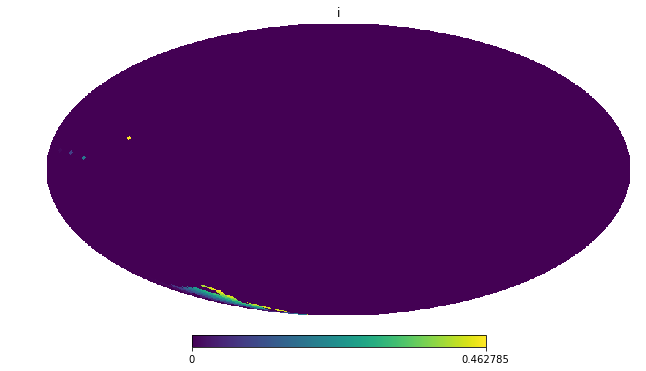

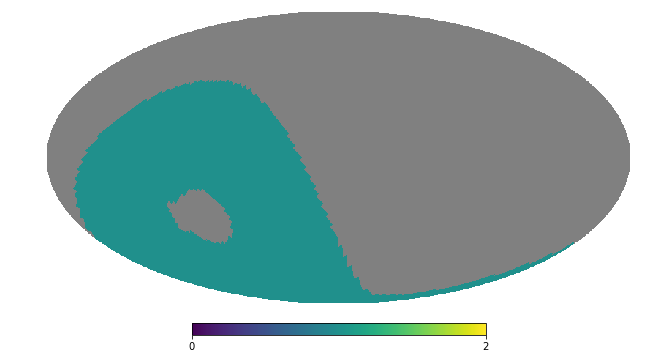

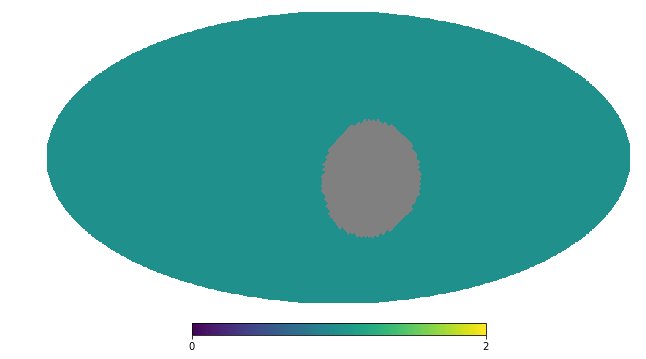

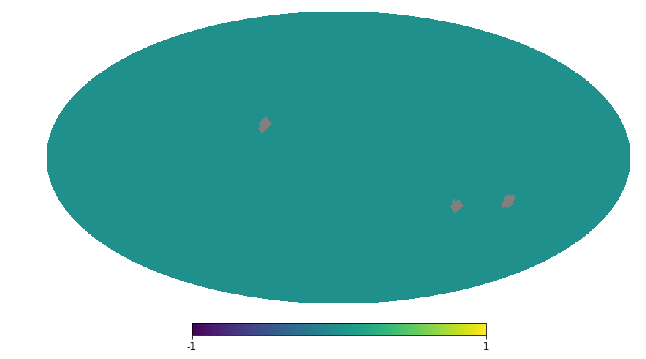

In [31]:
for bf in scheduler.survey_lists[1][2].basis_functions:
    val = bf(conditions)
    title = ''
    try:
        title += bf.filtername
    except:
        pass
    if np.size(val) > 1:
        hp.mollview(val, title=title)

In [27]:
scheduler.survey_lists[1][2].filtername1

'r'

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


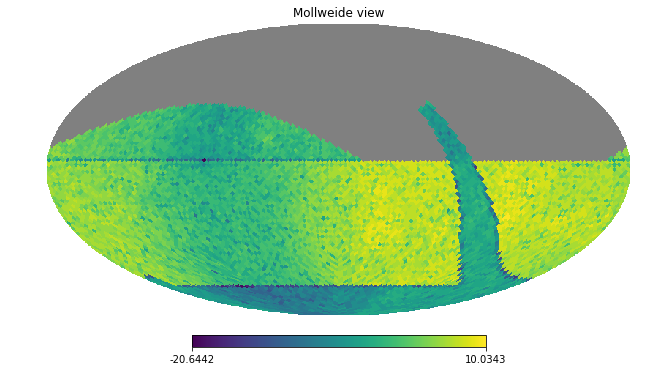

In [46]:
hp.mollview(scheduler.survey_lists[1][2].basis_functions[2](conditions))

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


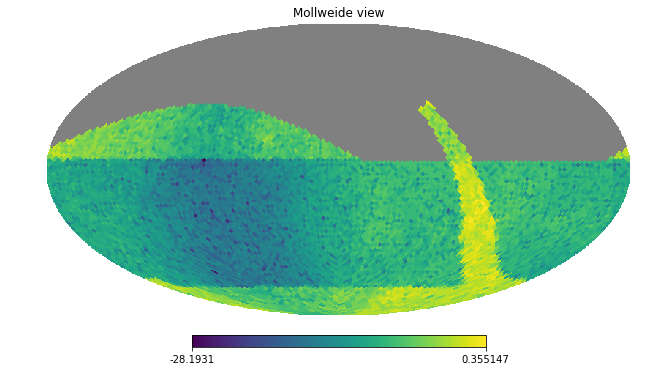

In [45]:
hp.mollview(scheduler.survey_lists[1][1].basis_functions[3](conditions))

In [47]:
# why are these two things different?
bf1 = scheduler.survey_lists[1][2].basis_functions[2]
bf2 = scheduler.survey_lists[1][1].basis_functions[3]

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


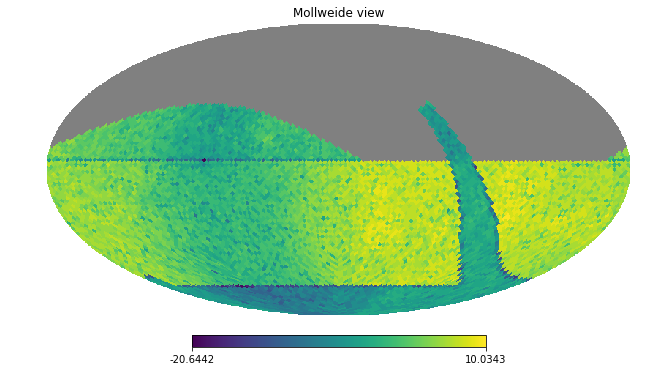

In [60]:
hp.mollview(bf1(conditions))

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


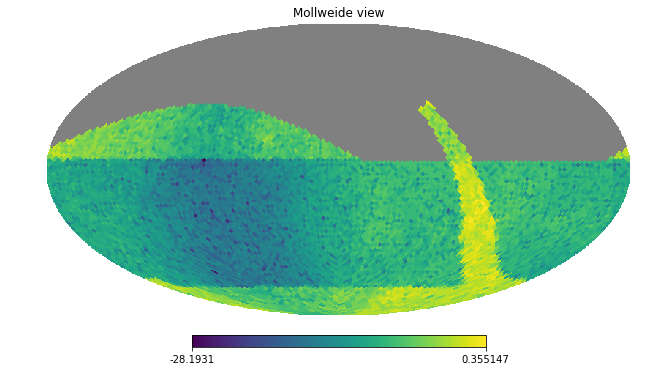

In [59]:
hp.mollview(bf2(conditions))

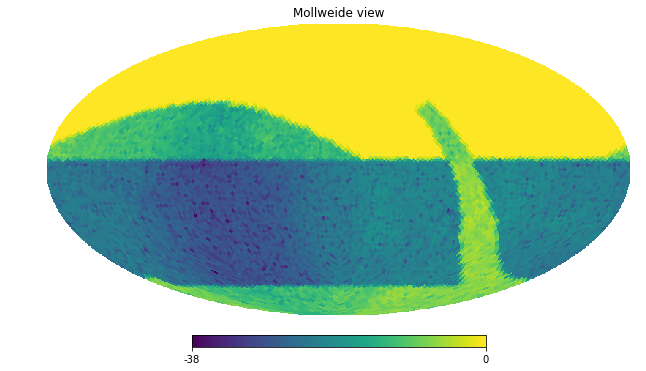

In [67]:
desired = bf1.footprint #/ bf1.all_footprints_sum * np.sum(bf1.survey_features['N_obs_all'].feature)
result1 = desired - bf1.survey_features['N_obs'].feature
hp.mollview(result1)

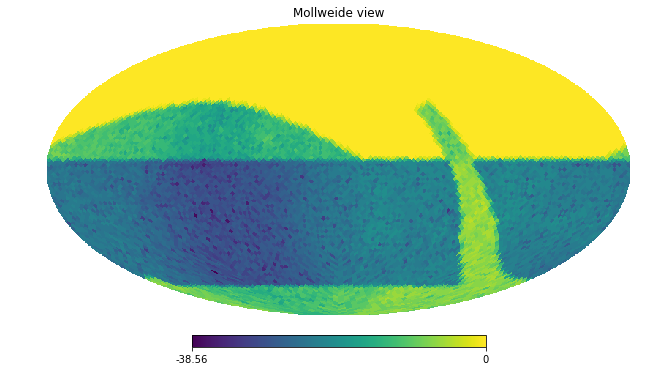

In [68]:
desired = bf2.footprint #/ bf2.all_footprints_sum #* np.sum(bf2.survey_features['N_obs_all'].feature)
result2 = desired - bf2.survey_features['N_obs'].feature
hp.mollview(result2)

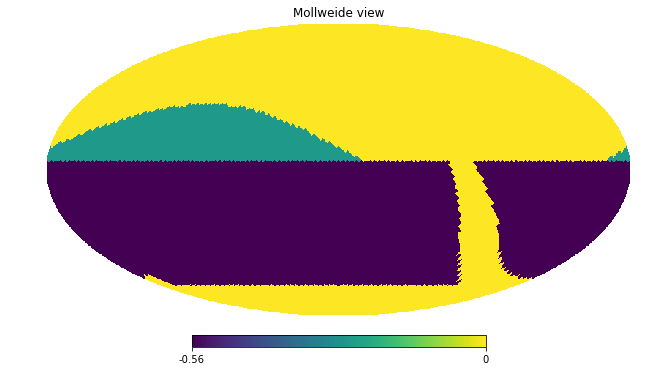

In [71]:
hp.mollview(bf2.footprint-bf1.footprint)

27686.690000000002

In [10]:
nums = np.arange(10)
indx1 = np.array([2,4,6,8])
indx2 = np.array([0,3])


In [11]:
nums[indx1][indx2], nums[indx1[indx2]]

(array([2, 8]), array([2, 8]))

array([2, 8])

In [6]:
nums[indx1][indx2] = 20
nums

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
nums[indx1[indx2]] = 20
nums

array([ 0,  1, 20,  3,  4,  5,  6,  7, 20,  9])